# Implementation of _Gaussian Processes for Probabilistic Estimates of Earthquake Ground Shaking: A 1-D Proof-of-Concept_, accepted in ML4PS Workshop @ NeurIPS 2024.

### Description

This notebook presents a proof-of-concept workflow for probabilistic earthquake ground motion prediction that accounts for inconsistencies between existing seismic velocity models. The approach is based on the probabilistic merging of overlapping seismic velocity models using scalable Gaussian Process (GP) regression. We fit a GP to two synthetic 1-D velocity profiles simultaneously, demonstrating that the predictive uncertainty accounts for the differences between them. We then draw samples of velocity models from the predictive distribution and simulate the acoustic wave equation using each sample as input. This results in a distribution of possible peak ground displacement (PGD) scenarios, reflecting the uncertainty in our knowledge of seismic velocities in the region.

### Instructions for Usage

- By default, the training code is commented out. If you wish to run the training code, simply uncomment it. These cells are indicated.
- Pre-trained models are found in the `trained_models/` directory. These are loaded by default.
- To run the notebook, execute each cell in sequential order. Make sure to run any necessary imports or variable definitions before executing other cells that depend on them.
- If you want to modify the input data or parameters, you can do so in the appropriate cells. Be sure to re-run any cells that depend on the modified data or parameters.

### Notebook Contents
- **[Imports](#Imports)**: Import necessary libraries and modules.
- **[Plotting Setup](#Plotting-Setup)**: Set up plotting parameters and color maps for visualizations.
- **[Workflow](#Workflow)**:
  - **[Input Data Generation](#Input-Data-Generation)**: Generate synthetic seismic velocity models using GPs.
  - **[Training the Models](#Training-the-Models)**: Train GP models on the generated data.
  - **[Generating Model Predictions](#Generating-Model-Predictions)**: Make predictions using the trained models and visualize the results.
  - **[Wave Propagation (Earthquake Simulations)](#Wave-Propagation-Earthquake-Simulations)**: Simulate earthquake wave propagation using the velocity model samples from the predictive distribution.
  - **[Calculating Probabilistic Estimate of Peak Ground Motion and Plotting](#Calculating-Probabilistic-Estimate-of-Peak-Ground-Motion-and-Plotting)**: Calculate and plot the probabilistic estimates of PGD.

### Citing this work
Coming soon ...

### Contributing, questions, and issues
If you have any suggestions, improvements, questions, or comments - please create an issue, submit a pull request, or [get in touch](mailto:sam.scivier@earth.ox.ac.uk).


### Imports

This section includes the necessary imports for the notebook. It covers general libraries such as NumPy, Matplotlib, and PyTorch, as well as a specialized library for Gaussian Processes (gpytorch) and other utilities. Custom utility functions for plotting, data generation, GP models, training, prediction, earthquake source functions, and wave propagation are also imported.

In [32]:
# general imports

import numpy as np
import matplotlib.pyplot as plt

import torch
import gpytorch as gp

from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from scipy.interpolate import CubicSpline

import warnings
warnings.filterwarnings('ignore')

In [33]:
# custom imports

from utils.plotting_utils import set_plotting_hyperparameters, truncate_colormap
from utils.data_gen_utils import set_seed, sample_gp_prior, normalise
from utils.gp_models import ApproximateGPModel
from utils.train_utils import train
from utils.prediction_utils import predict, pdf_num_sigma
from utils.source_fn import ricker_wavelet
from utils.wave_propagation import pml_damping_profile, finite_difference_solver

### Plotting Setup

In [34]:
# set plotting hyperparameters
set_plotting_hyperparameters()

# set colors
colors = ["#002147", "#E2C044", "#DE1F1F"]

blue_cmap = LinearSegmentedColormap.from_list("custom_cmap", [colors[0], "#ffffff"])

# Truncate the colormap
blue_cmap = truncate_colormap(blue_cmap, 0., 0.8)

## Workflow

The workflow consists of the following sections:

1. **Input Data Generation**: Synthetic seismic velocity models are generated as random functions sampled from Gaussian Processes (GPs).
2. **Training the Models**: GP models are trained on the generated data using two different objectives: Variational ELBO (typical SVGP objective) and the Predictive Log Likelihood (objective for Parametric Predictive GPR - PPGPR; Jankowiak et al., 2020).
3. **Generating Model Predictions**: Predictions are made using the trained models, and the results are visualized to compare the fits of the SVGP and PPGPR models.
4. **Wave Propagation (Earthquake Simulations)**: Earthquake wave propagation is simulated by solving the acoustic wave equation numerically, using the velocity model samples from the PPGPR predictive distribution as input. The peak ground displacement (PGD) for each velocity model sample is recorded.
5. **Calculating Probabilistic Estimate of Peak Ground Motion and Plotting**: The probabilistic estimates of PGD are calculated and plotted, reflecting the inconsistencies between existing estimates of seismic velocities.

### Input data generation

Synthetic seismic velocity models are generated as random functions sampled from Gaussian Processes (GPs). Two sets of coordinates are defined for the input velocity models, and samples are drawn from the GP prior using an RBF kernel with specified lengthscales. The second velocity model is created as a weighted superposition of the two GP samples to introduce both large-scale similarities and smaller-scale differences. The velocity models are then normalized to the desired range and plotted for visualization.

In [35]:
# set random seed
 
seed = 0
set_seed(seed)

In [36]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [37]:
domain_size = 4  # depth of domain
n_points = 25   # number of data points per input velocity model

# minimum and maximum seismic wave speeds in arbitrary units 
min_velocity = 3
max_velocity = 7

In [38]:
# create a staggered coordinate grid
# GPs can handle non-gridded data, but we use regularly spaced
# data here for simplicity

x1 = torch.linspace(0., 3.9, n_points)  # coordinates of the first input velocity model
x2 = torch.linspace(0.1, 4., n_points)  # coordinates of the second input velocity model

xs = [x1, x2]

In [39]:
n_samples = len(xs)
lengthscale = [0.6, 0.3]    # lengthscale of the kernel function for each input velocity model

# generate velocity models as samples from the GP prior
velocity_models = sample_gp_prior(gp.kernels.RBFKernel(), lengthscale, n_samples=n_samples, x_samples=xs)

print(velocity_models.shape)

torch.Size([2, 25])


In [40]:
# second velocity model is a weighted superposition of the two GP samples
# this creates large-scale similarities and smaller-scale differences between the two models
velocity_models[1] = (1 / 3) * velocity_models[1] + (2 / 3) * velocity_models[0]

# normalise the velocity models to the desired range
velocity_models = normalise(velocity_models, min_velocity, max_velocity)

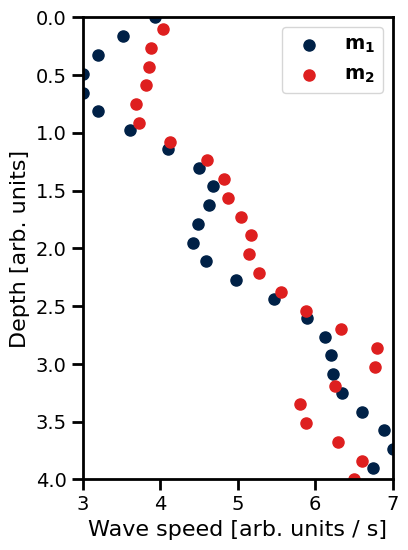

In [41]:
# plot the velocity models

fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax.scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
ax.scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[2])

ax.set(ylim=(0, 4), xlim=(min_velocity, max_velocity))
ax.set_ylabel("Depth [arb. units]")
ax.set_xlabel("Wave speed [arb. units / s]")

ax.invert_yaxis()

ax.legend()

plt.show()

### Training the Models

The training data consists of concatenated coordinates and velocity values from the generated velocity models. Initial inducing points are set for the Sparse Variational Gaussian Process (SVGP) and Parametric Predictive Gaussian Process Regression (PPGPR) models. Both models are initialized with an RBF kernel and Gaussian likelihoods. Training hyperparameters, including learning rate and number of iterations, are defined. The models can be trained using the provided training function (commented out by default). Pre-trained models and likelihoods are loaded by default.

In [42]:
# set the training data
train_x = torch.cat([x for x in xs], dim=0).to(device)
train_y = torch.cat([y for y in velocity_models], dim=0).to(device)

print(train_x.shape, train_y.shape)

torch.Size([50]) torch.Size([50])


In [43]:
# set initial locations of the inducing points
num_inducing_points = 20
inducing_points = torch.linspace(0, 4, num_inducing_points)

In [44]:
# initialize the SVGP and PPGPR models
ppgpr = ApproximateGPModel(
    inducing_points=inducing_points,
    kernel=gp.kernels.RBFKernel(),
).to(device)
svgp = ApproximateGPModel(
    inducing_points=inducing_points,
    kernel=gp.kernels.RBFKernel(),
).to(device)

# set Gaussian likelihoods for the models
likelihood_ppgpr = gp.likelihoods.GaussianLikelihood().to(device)
likelihood_svgp = gp.likelihoods.GaussianLikelihood().to(device)

In [45]:
# set the training hyperparameters

learning_rate = 0.05
training_iterations = 4000

In [46]:
# # UNCOMMENT TO TRAIN AND SAVE THE MODELS

# ppgpr, likelihood_ppgpr = train(
#     model_name="PPGPR",
#     model=ppgpr,
#     likelihood=likelihood_ppgpr,
#     train_x=train_x,
#     train_y=train_y,
#     learning_rate=learning_rate,
#     training_iterations=training_iterations,
#     objective_type="ppgpr",
#     device=device,
# )

# svgp, likelihood_svgp = train(
#     model_name="SVGP",
#     model=svgp,
#     likelihood=likelihood_svgp,
#     train_x=train_x,
#     train_y=train_y,
#     learning_rate=learning_rate,
#     training_iterations=training_iterations,
#     objective_type="svgp",
#     device=device,
# )

# # Save the models and likelihoods
# torch.save(ppgpr.state_dict(), "./trained_models/ppgpr.pth")
# torch.save(svgp.state_dict(), "./trained_models/svgp.pth")

# torch.save(likelihood_ppgpr.state_dict(), "./trained_models/likelihood_ppgpr.pth")
# torch.save(likelihood_svgp.state_dict(), "./trained_models/likelihood_svgp.pth")

In [47]:
# load the models and likelihoods
if device.type == "cuda":
    device = torch.device("cpu")

    train_x = train_x.to(device)
    train_y = train_y.to(device)

state_dict_ppgpr = torch.load("./trained_models/ppgpr.pth", map_location=device)
state_dict_svgp = torch.load("./trained_models/svgp.pth", map_location=device)

state_dict_likelihood_ppgpr = torch.load("./trained_models/likelihood_ppgpr.pth", map_location=device)
state_dict_likelihood_svgp = torch.load("./trained_models/likelihood_svgp.pth", map_location=device)

ppgpr.load_state_dict(state_dict_ppgpr)
svgp.load_state_dict(state_dict_svgp)

ppgpr.eval()
svgp.eval()

likelihood_ppgpr.load_state_dict(state_dict_likelihood_ppgpr)
likelihood_svgp.load_state_dict(state_dict_likelihood_svgp)

likelihood_ppgpr.eval()
likelihood_svgp.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Generating Model Predictions

The trained SVGP and PPGPR models are used to make predictions at the test points. The predictive PDFs are visualised (in terms of the number of standard deviations from the mean) - as well as samples from each of the predictive distributions, to enable comparison between the SVGP and PPGPR models. The 200 velocity model samples from the PPGPR predictive distribution, to be used in the wave propagation, are also plotted.

In [48]:
# set the test points

num_test_points = 201

test_x = torch.linspace(0, domain_size, num_test_points).to(device)

In [49]:
# produce model predictions for identical models trained using the PPGPR and SVGP objectives, respectively

mean_ppgpr, std_ppgpr, out_samples_ppgpr = predict(
    model=ppgpr,
    x=test_x,
    likelihood=None,
    num_samples=3,
)

mean_svgp, std_svgp, out_samples_svgp = predict(
    model=svgp,
    x=test_x,
    likelihood=likelihood_svgp,
    num_samples=3,
)

In [50]:
# calculate the value of the predictive pdf at the test points, as the number of standard deviations from the predictive mean
# used for plotting

test_velocities = torch.linspace(2., 8., num_test_points)

n_sigma_pdf_ppgpr = pdf_num_sigma(
    model=ppgpr,
    test_coordinates=test_x,
    test_velocities=test_velocities,
    likelihood=None,
    num_sigma_clip=5.,
)

n_sigma_pdf_svgp = pdf_num_sigma(
    model=svgp,
    test_coordinates=test_x,
    test_velocities=test_velocities,
    likelihood=likelihood_svgp,
    num_sigma_clip=5.,
)

In [51]:
# generate many samples of velocity models from the PPGPR predictive distribution
num_vmodel_samples = 200

_, _, velocity_samples = predict(
    model=ppgpr,
    x=test_x,
    likelihood=None,
    num_samples=num_vmodel_samples,
)

#### Plotting GP Fusion Results

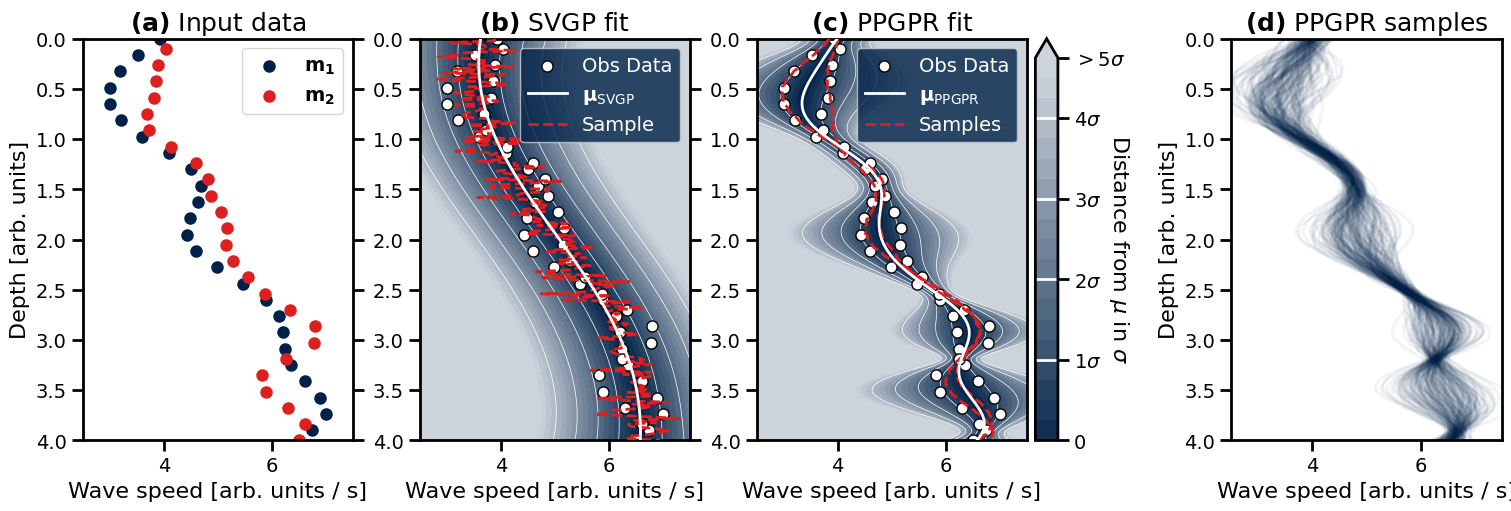

In [52]:
# plot the input data, the SVGP fit, the PPGPR fit, and the velocity samples from the PPGPR predictive distribution

gs_kw = dict(width_ratios=[12, 12, 12, 1, 0.5, 12])

fig, axs = plt.subplots(1, 6, figsize=(15, 5), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    if col == 0:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 1:
        ax.tick_params(right=True)

    if col != 3:
        ax.set_xlabel("Wave speed [arb. units / s]")

axs[0].scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color=colors[0])
axs[0].scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color=colors[2])

axs[0].legend(loc="upper right")

c = axs[1].contourf(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[1].contour(test_velocities, test_x, n_sigma_pdf_svgp.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[1].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[1].plot(mean_svgp, test_x, label=r"$\bf{\mu}_{\text{SVGP}}$", color="white", zorder=4)

axs[1].plot(out_samples_svgp[0], test_x, color=colors[2], ls="--", label=f"Sample", zorder=3)

axs[1].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

c = axs[2].contourf(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[2].contour(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[2].scatter(train_y, train_x, color="white", edgecolors="black", label="Obs Data", zorder=2)
axs[2].plot(mean_ppgpr, test_x, label=r"$\bf{\mu}_{\text{PPGPR}}$", color="white", zorder=4)

for i in range(2):
    if i == 0:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", label=f"Samples", zorder=3)
    else:
        axs[2].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", zorder=3)

axs[2].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

cbar = fig.colorbar(c, cax=axs[3])
cbar.set_ticks([0, 1, 2, 3, 4, 5])
cbar.set_ticklabels([r"0", r"1$\sigma$", r"2$\sigma$", r"3$\sigma$", r"4$\sigma$", r"$>$5$\sigma$"])
cbar.set_label("Distance from $\mu$ in $\sigma$", rotation=270)

axs[3].invert_yaxis()

axs[4].axis("off")

for i in range(1, 5):
    cbar.ax.axhline(i, color="white", lw=2)

for i in range(num_vmodel_samples):
    axs[5].plot(velocity_samples[i], np.linspace(0, 4, num_test_points), color=colors[0], alpha=0.05)

axs[5].set_ylabel("Depth [arb. units]")

axs[0].set_title(r"$\bf{(a)}$ Input data")
axs[1].set_title(r"$\bf{(b)}$ SVGP fit")
axs[2].set_title(r"$\bf{(c)}$ PPGPR fit")
axs[5].set_title(r"$\bf{(d)}$ PPGPR samples")

# plt.savefig("./figures/data_fit_samples.pdf", bbox_inches="tight")

plt.show()

In [53]:
# interpolate the two input models using cubic splines

interpolated_models = np.zeros((2, num_test_points))

for i in range(2):
    cs = CubicSpline(xs[i], velocity_models[i])
    interpolated_models[i] = cs(np.linspace(0, 4, num_test_points))

In [54]:
# calculate RMSE with respect to ideal maximum likelihood estimation result

rmse_mu_svgp = torch.sqrt(torch.mean((mean_svgp - (interpolated_models[0] + interpolated_models[1]) / 2) ** 2))
rmse_mu_ppgpr = torch.sqrt(torch.mean((mean_ppgpr - (interpolated_models[0] + interpolated_models[1]) / 2) ** 2))

rmse_var_svgp = torch.sqrt(torch.mean((std_svgp ** 2 - ((interpolated_models[0] - interpolated_models[1]) / 2) ** 2) ** 2))
rmse_var_ppgpr = torch.sqrt(torch.mean((std_ppgpr ** 2 - ((interpolated_models[0] - interpolated_models[1]) / 2) ** 2) ** 2))

print(f"RMSE SVGP mean: {rmse_mu_svgp:.3f}")
print(f"RMSE PPGPR mean: {rmse_mu_ppgpr:.3f}")

print(f"RMSE SVGP variance: {rmse_var_svgp:.3f}")
print(f"RMSE PPGPR variance: {rmse_var_ppgpr:.3f}")

RMSE SVGP mean: 0.243
RMSE PPGPR mean: 0.045
RMSE SVGP variance: 0.098
RMSE PPGPR variance: 0.012


### Wave Propagation (Earthquake Simulations)

In this section, we simulate earthquake wave propagation by solving the 1-D acoustic wave equation numerically for each of the velocity model samples from the PPGPR predictive distribution. We implement a finite difference method to solve the wave equation. A perfectly-matched layer (PML) boundary condition is applied (according to Chern, 2019) to absorb reflections at the bottom boundary. The earthquake source time function is defined as the Ricker wavelet. The peak ground displacement (PGD) is recorded for each simulation, and the results are visualised.

In [55]:
# Wave propagation hyperparameters

num_test_points = 201
dx = domain_size / (num_test_points - 1)
courant_number = 0.6
dt = courant_number * dx / max_velocity
nt = 600

time = np.arange(nt) * dt
center_frequency = 12. / (nt * dt)
time_shift = 2. / center_frequency

amplitude_scaling = 500.

src_idx = int(num_test_points * 2 / 3)

The earthquake source time function used in this study is the Ricker wavelet. It is essentially the second derivative of a Gaussian and is defined here by a central frequency and a time shift.

In [56]:
source = ricker_wavelet(time, center_frequency, time_shift)

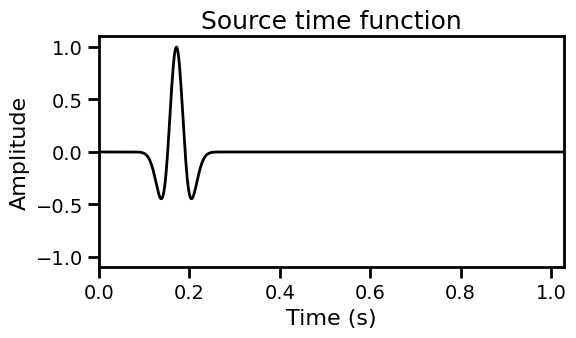

In [57]:
# plot the source time function
plt.figure(figsize=(6, 3))
plt.plot(time, source, color="black")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1.1, 1.1)
plt.xlim(0, nt * dt)
plt.title("Source time function")

plt.show()

In [58]:
source *= amplitude_scaling

In [59]:
# generate the perfectly-matched layer damping profile for the absorbing boundary (Chern, 2019)

num_pml_points = 25

damping = pml_damping_profile(
    num_coordinates=num_test_points,
    num_pml_points=num_pml_points,
    max_damping=20 * (1 + 2 * max_velocity / 3),
)  # PML damping profile

#### Solving the wave equation and recording peak ground displacement for velocity model samples

In [60]:
# simulate wave propagation using velocity samples from the PPGPR predictive distribution

peak_amplitudes, plotting_wavefield = finite_difference_solver(
    velocity_models=velocity_samples,
    num_coordinates=num_test_points,
    num_time_steps=nt,
    delta_x=dx,
    delta_t=dt,
    source=source,
    source_location=src_idx,
    damping=damping,
)

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:07<00:00, 75.32it/s]


#### Solving the wave equation and recording peak ground displacement for input velocity models

In [61]:
peak_amplitudes_input_models, plotting_wavefield_input_models = finite_difference_solver(
    velocity_models=interpolated_models,
    num_coordinates=num_test_points,
    num_time_steps=nt,
    delta_x=dx,
    delta_t=dt,
    source=source,
    source_location=src_idx,
    damping=damping,
)

100%|██████████| 600/600 [00:04<00:00, 126.60it/s]


### Calculating Probabilistic Estimate of Peak Ground Motion and Plotting

In [62]:
# calculate statistics of the PGD distribution

median = np.median(peak_amplitudes[:, -1])  # median peak ground displacement

# calulate the middle 70% of the peak ground displacements
lower_bound = np.percentile(peak_amplitudes[:, -1], 15)
upper_bound = np.percentile(peak_amplitudes[:, -1], 85)

d_med_lower = median - lower_bound
d_med_upper = upper_bound - median

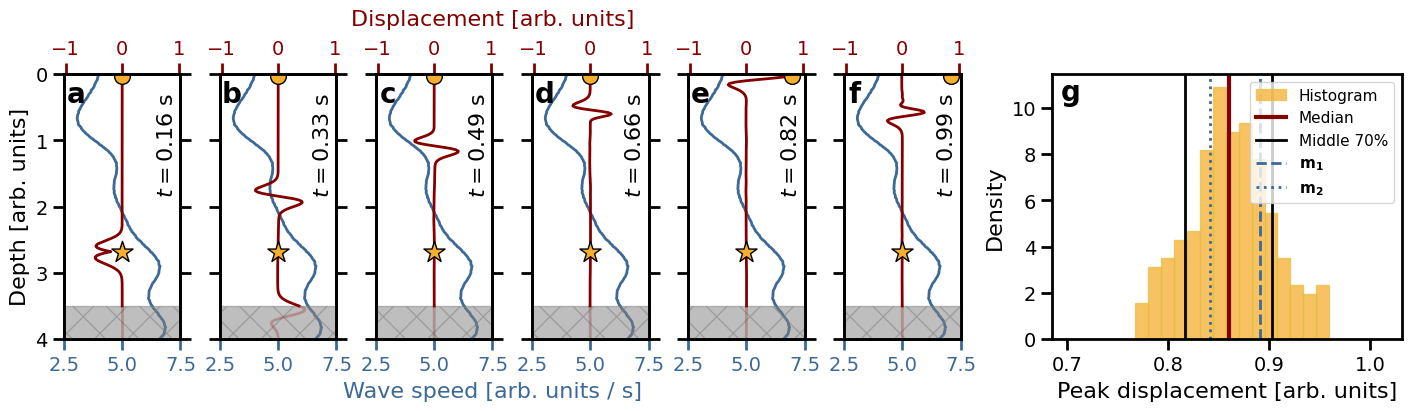

In [ ]:
x = np.linspace(0., 4., num_test_points)

gs_kw = dict(width_ratios=[3, 3, 3, 3, 3, 3, 9])

fig, axs = plt.subplots(1, 7, figsize=(14, 4), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat[:-1]):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    ax2 = ax.twiny()

    ax2.set_xlim(- (median + 4 * d_med_upper), median + 4 * d_med_upper)

    if col == 5:
        pass
    else:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 2:
        ax2.set_xlabel("Displacement [arb. units]", color="#830000", labelpad=10, x=1)
        ax.set_xlabel("Wave speed [arb. units / s]", color="#3C6997", labelpad=5, x=1)

    if col != 0:
        ax.set_yticklabels([])

    ax.tick_params(axis='x', labelcolor="#3C6997", color="#3C6997")
    ax2.tick_params(axis='x', labelcolor="#830000", color="#830000")

    N = 96

    ax.text(0.8, 0.55, f"$t = {N * (1 + col) * dt:0.2f}$ s", transform=ax.transAxes, fontsize=16, rotation="vertical")

    ax2.plot(plotting_wavefield[N * (1 + col), :-num_pml_points], x[:-num_pml_points], color="#830000")
    ax2.plot(plotting_wavefield[N * (1 + col), -num_pml_points - 1:], x[-num_pml_points - 1:], color="#830000", alpha=0.25)
    ax.plot(velocity_samples[1], x, color="#3C6997")

    ax2.scatter(0, src_idx * dx, color="#F6AE2D", marker="*", s=256, edgecolor="black", zorder=5)

    ax2.scatter(peak_amplitudes[1, N * (1 + col)], 0.025, color="#F6AE2D", marker="o", s=128, edgecolor="black", zorder=2)

    ax2.fill_between([-10., 10.], domain_size - num_pml_points * dx, 4, color="tab:grey", alpha=0.5, hatch="x")

axs[-1].hist(peak_amplitudes[:, -1], bins=15, density=True, color="#F6AE2D", alpha=0.75, label="Histogram", edgecolor=colors[1])

axs[-1].axvline(median, color="#830000", lw=3, label="Median")
axs[-1].axvline(lower_bound, color="black", lw=2, label="Middle 70%")
axs[-1].axvline(upper_bound, color="black", lw=2)

axs[-1].axvline(peak_amplitudes_input_models[0, -1], color="#3C6997", lw=2, ls="--", label=r"$\bf{m}_1$")
axs[-1].axvline(peak_amplitudes_input_models[1, -1], color="#3C6997", lw=2, ls=":", label=r"$\bf{m}_2$")

axs[-1].set_xlim([median - 4 * d_med_lower, median + 4 * d_med_upper])

# axs[-1].set_yticks([])
axs[-1].set_xlabel("Peak displacement [arb. units]", labelpad=5)
axs[-1].set_ylabel("Density", labelpad=5)

axs[-1].legend(fontsize=11, loc="upper right")

lposx = 0.1
lposy = 0.925

axs[0].text(lposx, lposy, r"$\bf{a}$", transform=axs[0].transAxes, fontsize=20, ha="center", va="center")
axs[1].text(lposx, lposy, r"$\bf{b}$", transform=axs[1].transAxes, fontsize=20, ha="center", va="center")
axs[2].text(lposx, lposy, r"$\bf{c}$", transform=axs[2].transAxes, fontsize=20, ha="center", va="center")
axs[3].text(lposx, lposy, r"$\bf{d}$", transform=axs[3].transAxes, fontsize=20, ha="center", va="center")
axs[4].text(lposx, lposy, r"$\bf{e}$", transform=axs[4].transAxes, fontsize=20, ha="center", va="center")
axs[5].text(lposx, lposy, r"$\bf{f}$", transform=axs[5].transAxes, fontsize=20, ha="center", va="center")
axs[6].text(0.05, lposy, r"$\bf{g}$", transform=axs[6].transAxes, fontsize=20, ha="center", va="center")

# plt.savefig("./figures/wavefield_histogram.pdf", bbox_inches="tight")

plt.show()

In [64]:
def set_poster_plotting_hyperparameters():
    
    # set font sizes
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14

    # set linewidths and tick linewidths
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['ytick.major.width'] = 2

    # increase tick length
    plt.rcParams['xtick.major.size'] = 8
    plt.rcParams['ytick.major.size'] = 8

    # increase plot line widths
    plt.rcParams['lines.linewidth'] = 2

    # increase marker sizes
    plt.rcParams['lines.markersize'] = 8

    # set transparent figure and axes background
    plt.rcParams['figure.facecolor'] = 'none'
    plt.rcParams['axes.facecolor'] = 'none'

    # set all lines, labels, and markers to white
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['legend.facecolor'] = 'none'
    plt.rcParams['legend.edgecolor'] = 'white'


set_poster_plotting_hyperparameters()

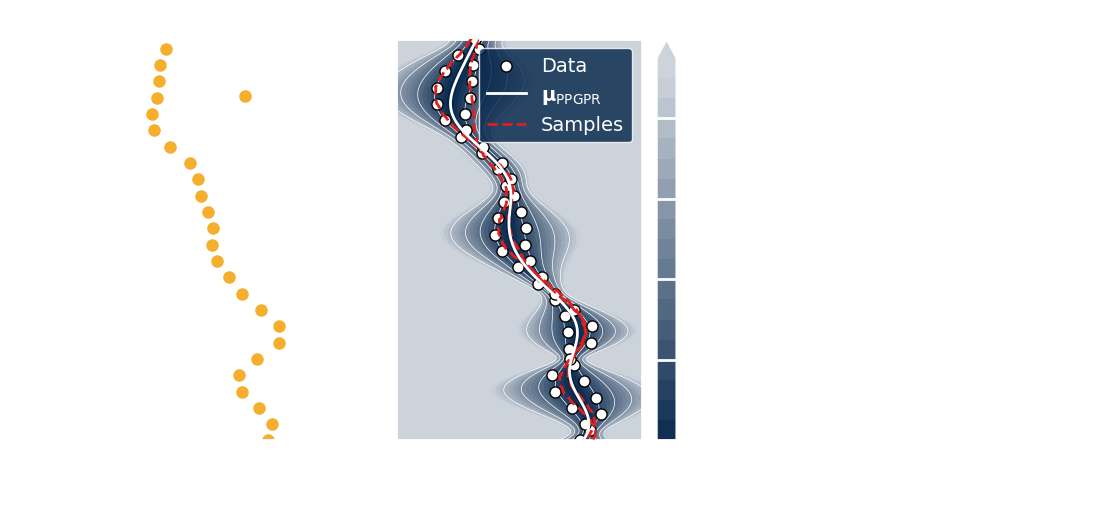

In [ ]:
# plot the input data, the PPGPR fit, and the velocity samples from the PPGPR predictive distribution

gs_kw = dict(width_ratios=[12, 12, 1, 0.5, 12])

fig, axs = plt.subplots(1, 5, figsize=(11, 5), constrained_layout=True, gridspec_kw=gs_kw)

for col, ax in enumerate(axs.flat):

    ax.set_xlim(2, 8)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    if col == 0:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col != 2:
        ax.set_xlabel("Wave speed [arb. units / s]")

axs[0].scatter(velocity_models[0], xs[0], label=r"$\bf{m}_1$", color="white")
axs[0].scatter(velocity_models[1], xs[1], label=r"$\bf{m}_2$", color="#F6AE2D")

axs[0].legend(loc="upper right")

c = axs[1].contourf(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=20, cmap=blue_cmap, alpha=1., zorder=0, extend="max")
axs[1].contour(test_velocities, test_x, n_sigma_pdf_ppgpr.T, levels=[1, 2, 3, 4], colors="white", linewidths=0.5, zorder=1)
axs[1].scatter(train_y, train_x, color="white", edgecolors="black", label="Data", zorder=2)
axs[1].plot(mean_ppgpr, test_x, label=r"$\bf{\mu}_{\text{PPGPR}}$", color="white", zorder=4)

for i in range(2):
    if i == 0:
        axs[1].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", label=f"Samples", zorder=3)
    else:
        axs[1].plot(out_samples_ppgpr[i], test_x, color=colors[2], ls="--", zorder=3)

axs[1].legend(facecolor=colors[0], labelcolor="white", loc="upper right")

cbar = fig.colorbar(c, cax=axs[2])
cbar.set_ticks([0, 1, 2, 3, 4, 5])
cbar.set_ticklabels([r"0", r"1$\sigma$", r"2$\sigma$", r"3$\sigma$", r"4$\sigma$", r"$>$5$\sigma$"])
cbar.set_label("Distance from $\mu$ in $\sigma$", rotation=270)

axs[2].invert_yaxis()

axs[3].axis("off")

for i in range(1, 5):
    cbar.ax.axhline(i, color="white", lw=2)

for i in range(num_vmodel_samples):
    axs[4].plot(velocity_samples[i], np.linspace(0, 4, num_test_points), color="white", alpha=0.075)

axs[4].set_ylabel("Depth [arb. units]")

axs[0].set_title(r"$\bf{(a)}$ Input data")
axs[1].set_title(r"$\bf{(b)}$ PPGPR fit")
axs[4].set_title(r"$\bf{(c)}$ PPGPR samples")

# plt.savefig("./figures/data_fit_samples_poster.svg", bbox_inches="tight")

plt.show()

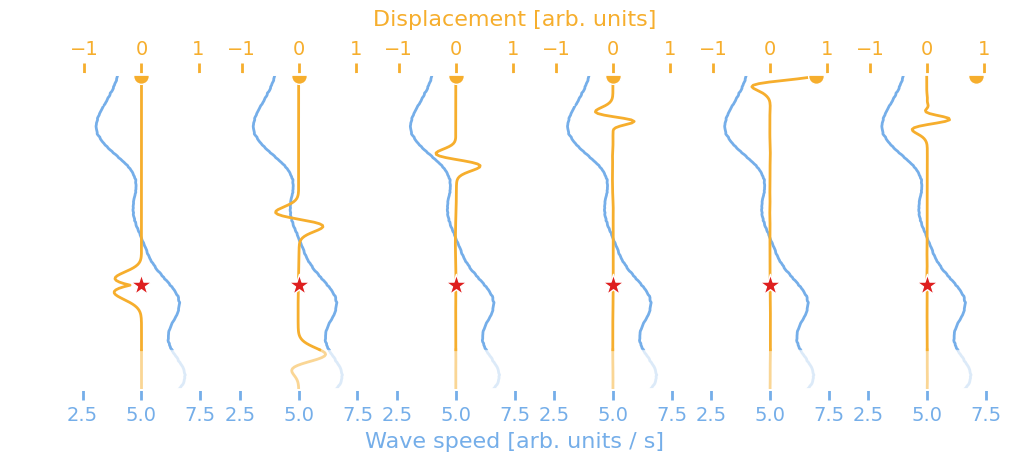

In [ ]:
colors_poster = ["#F6AE2D", "#75AEE9"]

fig, axs = plt.subplots(1, 6, figsize=(10, 4.5), constrained_layout=True)

for col, ax in enumerate(axs.flat):

    ax.set_xlim(2.5, 7.5)
    ax.set_ylim(0, 4)

    ax.invert_yaxis()

    ax2 = ax.twiny()

    ax2.set_xlim(- (median + 4 * d_med_upper), median + 4 * d_med_upper)

    if col == 5:
        pass
    else:
        ax.tick_params(right=True)

    if col == 0:
        ax.set_ylabel("Depth [arb. units]")

    if col == 2:
        ax2.set_xlabel("Displacement [arb. units]", color=colors_poster[0], labelpad=10, x=1)
        ax.set_xlabel("Wave speed [arb. units / s]", color=colors_poster[1], labelpad=5, x=1)

    if col != 0:
        ax.set_yticklabels([])

    ax.tick_params(axis='x', labelcolor=colors_poster[1], color=colors_poster[1])
    ax2.tick_params(axis='x', labelcolor=colors_poster[0], color=colors_poster[0])

    N = 96

    ax.text(0.8, 0.55, f"$t = {N * (1 + col) * dt:0.2f}$ s", transform=ax.transAxes, fontsize=16, rotation="vertical")

    ax2.plot(plotting_wavefield[N * (1 + col), :-num_pml_points], x[:-num_pml_points], color=colors_poster[0])
    ax2.plot(plotting_wavefield[N * (1 + col), -num_pml_points - 1:], x[-num_pml_points - 1:], color=colors_poster[0], alpha=0.5, zorder=5)
    ax.plot(velocity_samples[1, :-num_pml_points], x[:-num_pml_points], color=colors_poster[1])
    ax.plot(velocity_samples[1, -num_pml_points - 1:], x[-num_pml_points - 1:], color=colors_poster[1], alpha=0.5, zorder=5)

    ax2.scatter(0, src_idx * dx, color=colors[2], marker="*", s=256, edgecolor="white", zorder=5)

    ax2.scatter(peak_amplitudes[1, N * (1 + col)], 0.025, color=colors_poster[0], marker="o", s=128, edgecolor="white", zorder=2)

    ax2.fill_between([-10., 10.], domain_size - num_pml_points * dx, 4, color="white", alpha=0.5, zorder=0)

lposx = 0.1
lposy = 0.925

axs[0].text(lposx, lposy, r"$\bf{a}$", transform=axs[0].transAxes, fontsize=20, ha="center", va="center")
axs[1].text(lposx, lposy, r"$\bf{b}$", transform=axs[1].transAxes, fontsize=20, ha="center", va="center")
axs[2].text(lposx, lposy, r"$\bf{c}$", transform=axs[2].transAxes, fontsize=20, ha="center", va="center")
axs[3].text(lposx, lposy, r"$\bf{d}$", transform=axs[3].transAxes, fontsize=20, ha="center", va="center")
axs[4].text(lposx, lposy, r"$\bf{e}$", transform=axs[4].transAxes, fontsize=20, ha="center", va="center")
axs[5].text(lposx, lposy, r"$\bf{f}$", transform=axs[5].transAxes, fontsize=20, ha="center", va="center")

# plt.savefig("./figures/wave_propagation_poster.svg", bbox_inches="tight")

plt.show()

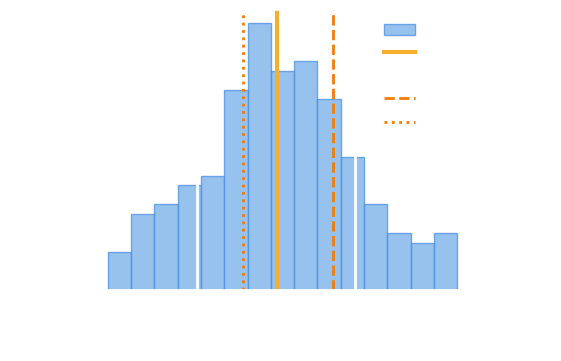

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5), constrained_layout=True)

ax.hist(peak_amplitudes[:, -1], bins=15, density=True, color=colors_poster[1], alpha=0.75, label="Histogram", edgecolor="#4A90E2")

ax.axvline(median, color=colors_poster[0], lw=3, label="Median")
ax.axvline(lower_bound, color="white", lw=2, label="Middle 70%")
ax.axvline(upper_bound, color="white", lw=2)

ax.axvline(peak_amplitudes_input_models[0, -1], color="#F57C00", lw=2, ls="--", label=r"$\bf{m}_1$")
ax.axvline(peak_amplitudes_input_models[1, -1], color="#F57C00", lw=2, ls=":", label=r"$\bf{m}_2$")
ax.set_xlim([0.75, 1.])

ax.set_xlabel("Peak displacement [arb. units]")
ax.set_ylabel("Density")

ax.legend(fontsize=11, loc="upper right")

# plt.savefig("./figures/peak_displacement_poster.svg", bbox_inches="tight")

plt.show()